#Import Packeges


In [6]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Set seed for reproducibility
np.random.seed(42)


# Parameters

In [7]:
# Parameters
devices = ["Heating", "Fridge", "Fan", "Oven", "Washing Machine", "Dryer", "Cooler"]
households = 50  # Number of households
observations = 100  # Number of observations per device per household
rtp_prices = np.random.uniform(low=0.1, high=0.5, size=(observations, 1))  # Random RTP prices

# Generate random device usage data for 50 households
usage_data = {f'Household {i+1}': np.random.uniform(0.1, 1.5, (observations, len(devices))) for i in range(households)}


# Assign epsilon values (privacy budgets) for each household

In [ ]:
# Assign epsilon values (privacy budgets) for each household
epsilon_values = {f'Household {i+1}': (6.73 if i == 0 else np.random.uniform(0.1, 15.0)) for i in range(households)}


# Local training for each household with individual models

In [ ]:
# Local training for each household with individual models
local_models = {}
X_households = {}
y_households = {}

for key in usage_data:
    # Prepare local data for each household
    X_households[key] = usage_data[key]
    y_households[key] = np.sum(usage_data[key] * rtp_prices, axis=1)

    # Train individual RandomForest model for each household
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_households[key], y_households[key])
    local_models[key] = model


# Aggregate the predictions from each household to simulate federated averaging

In [ ]:
# Aggregate the predictions from each household to simulate federated averaging
X_regional = np.vstack([usage_data[key] for key in usage_data])  # Regional data as a stack of all household data


# Initialize an array to store the aggregated predictions for each household

In [ ]:
# Initialize an array to store the aggregated predictions for each household
y_pred_agg = np.zeros((X_regional.shape[0],))

# To aggregate correctly, iterate through each household and place its predictions in the correct slice

In [ ]:
# To aggregate correctly, iterate through each household and place its predictions in the correct slice
start_index = 0
for key in local_models:
    # Predict using each local model
    y_pred = local_models[key].predict(X_households[key])

    # Get the slice of indices for this household
    end_index = start_index + len(y_pred)

    # Aggregate predictions from all local models, adding to the correct slice
    y_pred_agg[start_index:end_index] += y_pred

    # Move to the next slice for the next household
    start_index = end_index

# Average the predictions to simulate FedAvg
y_pred_agg /= households


# Train a global RandomForest model on the aggregated predictions

In [ ]:
# Train a global RandomForest model on the aggregated predictions
global_model = RandomForestRegressor(n_estimators=100, random_state=42)
global_model.fit(X_regional, y_pred_agg)


RandomForestRegressor(random_state=42)

# Explain the global model's predictions using SHAP (non-noisy regional SHAP explanation)

In [ ]:
# Explain the global model's predictions using SHAP (non-noisy regional SHAP explanation)
explainer = shap.Explainer(global_model, X_regional)
shap_values_without_noise = explainer(X_regional)

100%|===================| 4998/5000 [06:44<00:00]       

# Step 1: Apply Laplace noise to each household's SHAP values based on their epsilon values

In [ ]:
# Step 1: Apply Laplace noise to each household's SHAP values based on their epsilon values
shap_values_with_noise_list = []

for i, key in enumerate(local_models):
    explainer_local = shap.Explainer(local_models[key], X_households[key])
    shap_values_local = explainer_local(X_households[key])

    # Add Laplace noise based on household's epsilon value
    epsilon = epsilon_values[key]
    noise = np.random.laplace(0, 1/epsilon, shap_values_local.values.shape)
    noisy_shap_values = shap_values_local.values + noise

    shap_values_with_noise_list.append(
        shap.Explanation(
            values=noisy_shap_values,
            base_values=shap_values_local.base_values,
            data=X_households[key],
            feature_names=devices
        )
    )


# Step 2: Perform FedAvg on noisy SHAP values

In [ ]:
# Step 2: Perform FedAvg on noisy SHAP values
values_list = []
base_values_list = []
data_list = []

# Manually concatenate the noisy SHAP explanations
for shap_val in shap_values_with_noise_list:
    values_list.append(shap_val.values)
    base_values_list.append(shap_val.base_values)
    data_list.append(shap_val.data)

# Stack them to create a SHAP explanation object
shap_values_with_noise = shap.Explanation(
    values=np.vstack(values_list),
    base_values=np.hstack(base_values_list),
    data=np.vstack(data_list),
    feature_names=devices
)


# Step 3: Plot SHAP comparison - noisy zonal explanation vs. regional without noise

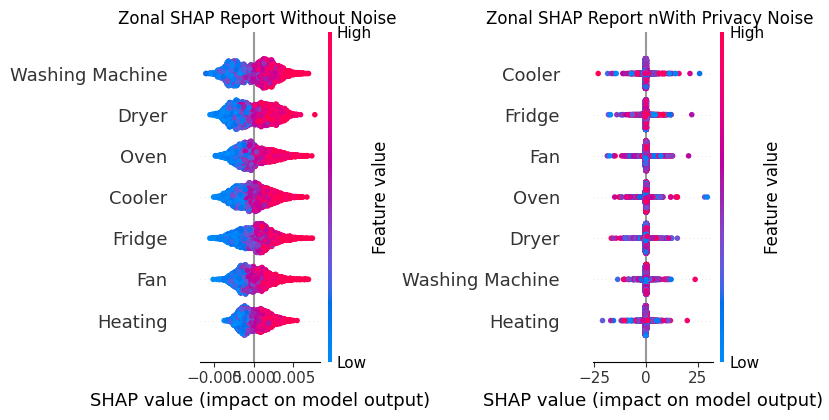

In [ ]:
# Step 3: Plot SHAP comparison - noisy zonal explanation vs. regional without noise

plt.figure(figsize=(30, 6))

# Plot SHAP summary plot without noise (regional)
plt.subplot(1, 2, 1)
shap.summary_plot(shap_values_without_noise, X_regional, feature_names=devices, show=False)
plt.title('Zonal SHAP Report Without Noise ')

# Plot SHAP summary plot with noise (zonal with noise after FedAvg)
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values_with_noise, X_regional, feature_names=devices, show=False)
plt.title('Zonal SHAP Report nWith Privacy Noise ')

# Show the plots
plt.tight_layout()
plt.show()

#introducing discount scheme and significant price drop after using energy efficient newer gadgets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Simulated historical electricity prices in Norway (Hourly data)
np.random.seed(42)
hours_in_day = 24
days_of_data = 30  # Simulating 30 days of historical data
historical_prices = np.random.uniform(low=0.1, high=0.3, size=(days_of_data, hours_in_day))


In [ ]:
# Peak hours: 7 AM to 10 AM and 5 PM to 10 PM
peak_hours = np.array([7, 8, 9, 17, 18, 19, 20, 21, 22])
non_peak_hours = np.setdiff1d(np.arange(hours_in_day), peak_hours)



In [ ]:
# Adjust prices: Higher prices during peak hours, lower prices during non-peak hours
for day in range(days_of_data):
    historical_prices[day, peak_hours] += np.random.uniform(0.1, 0.2, size=len(peak_hours))  # Higher prices during peak
    historical_prices[day, non_peak_hours] += np.random.uniform(0.0, 0.1, size=len(non_peak_hours))  # Lower prices non-peak

# Flatten the historical prices for forecasting
historical_prices_flattened = historical_prices.flatten()


In [ ]:
# Train RandomForestRegressor for forecasting
def train_forecast_model(historical_prices_flattened):
    lag = 24
    X, y = [], []
    for i in range(len(historical_prices_flattened) - lag):
        X.append(historical_prices_flattened[i:i + lag])
        y.append(historical_prices_flattened[i + lag])
    X, y = np.array(X), np.array(y)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    return model


In [ ]:
# Forecast electricity prices for next 24 hours based on the model
def forecast_prices(model, historical_prices_flattened):
    lag = 24
    current_input = historical_prices_flattened[-lag:]  # Use last 24 hours as input
    predicted_prices = []

    for _ in range(24):  # Predict for the next 24 hours
        next_pred = model.predict(current_input.reshape(1, -1))
        predicted_prices.append(next_pred[0])
        current_input = np.roll(current_input, -1)
        current_input[-1] = next_pred  # Update input

    return np.array(predicted_prices)

In [ ]:
# Simulate noisy zonal consumption data and train model
model = train_forecast_model(historical_prices_flattened)


In [ ]:
# Forecasted prices for old and new washing machine scenarios
predicted_prices_old = forecast_prices(model, historical_prices_flattened)  # Old prices (higher)
predicted_prices_new = predicted_prices_old * np.random.uniform(0.7, 0.9, size=(24,))  # New prices (lower due to efficient devices)

#Plot the curve



<ipython-input-51-5c17c34c7c02>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[-1] = next_pred  # Update input
<ipython-input-51-5c17c34c7c02>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[-1] = next_pred  # Update input
<ipython-input-51-5c17c34c7c02>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[-1] = next_pred  # Update input
<ipython-input-51-5c17c34c7c02>:47: DeprecationWarning: Conversion of an array with n

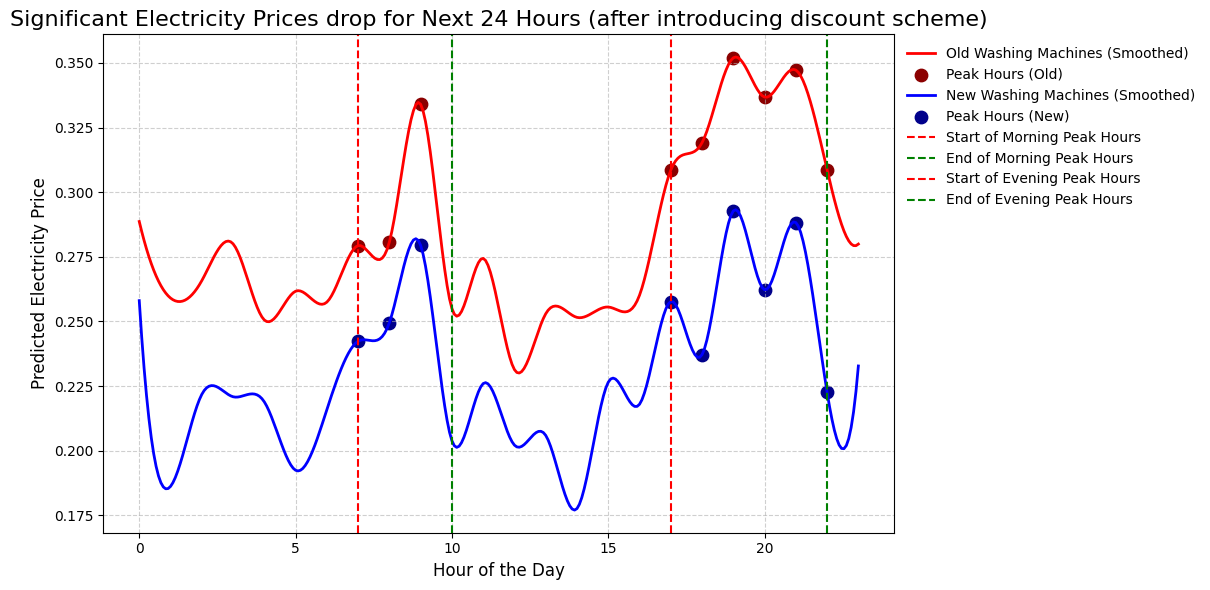

In [ ]:

# Smooth the curves using spline interpolation
hours_new = np.linspace(0, 23, 300)  # Create more points for smooth curve
splined_prices_old = make_interp_spline(np.arange(24), predicted_prices_old, k=3)(hours_new)
splined_prices_new = make_interp_spline(np.arange(24), predicted_prices_new, k=3)(hours_new)

# Plot the smooth curves
plt.figure(figsize=(12, 6))

# Plot the old washing machine scenario
plt.plot(hours_new, splined_prices_old, label='Old Washing Machines (Smoothed)', color='red', linewidth=2)
plt.scatter(peak_hours, predicted_prices_old[peak_hours], color='darkred', s=80, label='Peak Hours (Old)')

# Plot the new washing machine scenario
plt.plot(hours_new, splined_prices_new, label='New Washing Machines (Smoothed)', color='blue', linewidth=2)
plt.scatter(peak_hours, predicted_prices_new[peak_hours], color='darkblue', s=80, label='Peak Hours (New)')

# Add vertical lines for peak hours
plt.axvline(x=7, color='red', linestyle='--', label='Start of Morning Peak Hours', linewidth=1.5)
plt.axvline(x=10, color='green', linestyle='--', label='End of Morning Peak Hours', linewidth=1.5)
plt.axvline(x=17, color='red', linestyle='--', label='Start of Evening Peak Hours', linewidth=1.5)
plt.axvline(x=22, color='green', linestyle='--', label='End of Evening Peak Hours', linewidth=1.5)

# Customize the plot
plt.title('Significant Electricity Prices drop for Next 24 Hours (after introducing discount scheme)', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Predicted Electricity Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10, loc='upper right')

# Adjust the legend position to avoid blocking the plot
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Show the plot
plt.tight_layout()
plt.show()


#Multiple Query upperbound of Privacy

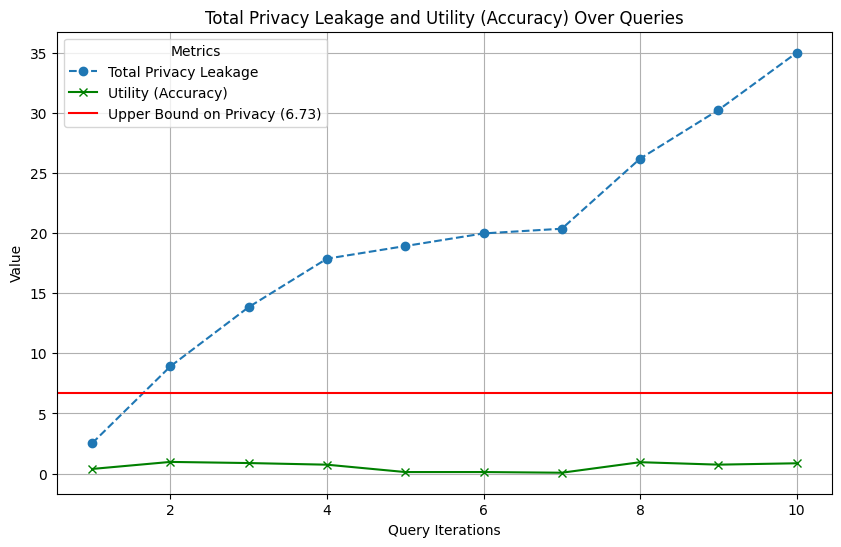

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



# Number of queries (n)
n = 10

# Generate random privacy budgets between 0 and 6.73
np.random.seed(42)
privacy_budgets_adjusted = np.random.uniform(0, 6.73, n)

# Define the total privacy leakage using the sum of adjusted privacy budgets
total_privacy_leakage = np.cumsum(privacy_budgets_adjusted)  # Summing epsilon budgets

# Define the iterations (queries)
iterations = np.arange(1, n + 1)

# Define a utility function that increases with epsilon (accuracy increases with less noise)
def utility(accuracy):
    return 1 / (1 + np.exp(-accuracy + 3))  # Sigmoid-like increase in accuracy

# Calculate utility for each query's privacy budget
utilities = [utility(eps) for eps in privacy_budgets_adjusted]

# Plot the results
plt.figure(figsize=(10, 6))

# Plot Total Privacy Leakage as per the constraint
plt.plot(iterations, total_privacy_leakage, label="Total Privacy Leakage", marker='o', linestyle='--')

# Plot Utility (Accuracy) with sigmoid increase and constant behavior
plt.plot(iterations, utilities, label="Utility (Accuracy)", marker='x', color='g')

# Highlight the threshold at 6.73
plt.axhline(y=6.73, color='r', linestyle='-', label='Upper Bound on Privacy (6.73)')

# Add labels and title
plt.title('Total Privacy Leakage and Utility (Accuracy) Over Queries')
plt.xlabel('Query Iterations')
plt.ylabel('Value')
plt.legend(title="Metrics")
plt.grid(True)

# Show the plot
plt.show()


#specific Query Utility is more than General Query

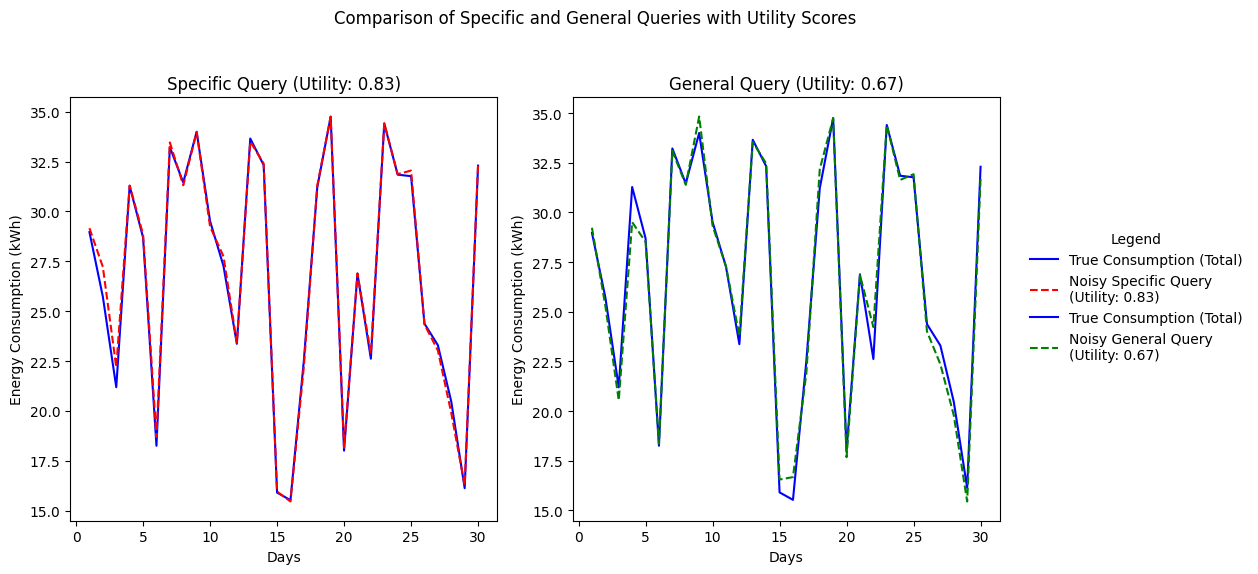

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example privacy budgets (epsilon values)
epsilon_specific = 5.0  # Specific query privacy budget (example)
epsilon_general = 2.0   # General query privacy budget (example)

# Define the utility function based on epsilon
def utility(epsilon):
    return 1 - (1 / (1 + epsilon))  # Accuracy increases as epsilon increases

# Calculate utility for both specific and general queries
utility_specific = utility(epsilon_specific)
utility_general = utility(epsilon_general)

# Simulated data for true consumption and noisy queries
days = np.arange(1, 31)  # 30 days

# Simulated energy consumption (kWh)
true_consumption = np.random.uniform(15, 35, size=30)

# Noisy consumption data based on specific and general queries
noisy_specific = true_consumption + np.random.laplace(0, 1.0/epsilon_specific, size=30)
noisy_general = true_consumption + np.random.laplace(0, 1.0/epsilon_general, size=30)

# Plot the comparison
plt.figure(figsize=(12, 6))

# Plot for Specific Query
plt.subplot(1, 2, 1)
plt.plot(days, true_consumption, label='True Consumption (Total)', color='b')
plt.plot(days, noisy_specific, label=f'Noisy Specific Query\n(Utility: {utility_specific:.2f})', linestyle='--', color='r')
plt.title(f"Specific Query (Utility: {utility_specific:.2f})")
plt.xlabel("Days")
plt.ylabel("Energy Consumption (kWh)")

# Plot for General Query
plt.subplot(1, 2, 2)
plt.plot(days, true_consumption, label='True Consumption (Total)', color='b')
plt.plot(days, noisy_general, label=f'Noisy General Query\n(Utility: {utility_general:.2f})', linestyle='--', color='g')
plt.title(f"General Query (Utility: {utility_general:.2f})")
plt.xlabel("Days")
plt.ylabel("Energy Consumption (kWh)")

# Create a combined legend box closer to the subplots
plt.figlegend(loc='center right', bbox_to_anchor=(1.05, 0.5), title="Legend", frameon=False)

# Add a common title
plt.suptitle('Comparison of Specific and General Queries with Utility Scores')

# Adjust layout to fit titles and legends
plt.tight_layout(rect=[0, 0.03, 0.85, 0.95])

# Show the plot
plt.show()


#24-hour consumption based on specific query local analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate 24-hour consumption data (in kWh) for washing machines (WM) and coolers (C) for Households 2 and 4
hours = np.arange(24)

# Base consumption values for Household 2 and 4 (randomly generated data)
consumption_household2_WM = np.random.uniform(0.5, 1.5, size=24)
consumption_household4_WM = np.random.uniform(0.7, 1.7, size=24)
consumption_household2_C = np.random.uniform(0.8, 2.0, size=24)
consumption_household4_C = np.random.uniform(0.9, 2.2, size=24)

# Aggregate total consumption for both households
total_consumption_WM = consumption_household2_WM + consumption_household4_WM
total_consumption_C = consumption_household2_C + consumption_household4_C

# Apply percentage reduction after price drop
percentage_reduction_WM = 0.10  # 10% reduction for WM
percentage_reduction_C = 0.12   # 12% reduction for C

total_consumption_after_WM = total_consumption_WM * (1 - percentage_reduction_WM)
total_consumption_after_C = total_consumption_C * (1 - percentage_reduction_C)

# Apply differential privacy noise using Laplace mechanism
epsilon = 0.8  # Privacy budget
def apply_laplace_noise(value, epsilon):
    noise = np.random.laplace(0, 1 / epsilon, size=24)
    return value + noise

noisy_consumption_WM = apply_laplace_noise(total_consumption_after_WM, epsilon)
noisy_consumption_C = apply_laplace_noise(total_consumption_after_C, epsilon)

# Plot the results
plt.figure(figsize=(12, 8))

# Plot for washing machines (WM)
plt.subplot(2, 1, 1)
plt.plot(hours, total_consumption_after_WM, label='Original WM Consumption', color='blue', linewidth=2)
plt.plot(hours, noisy_consumption_WM, label='Noisy WM Consumption', color='orange', linestyle='--', linewidth=2)
plt.fill_between(hours, total_consumption_after_WM, noisy_consumption_WM, color='orange', alpha=0.2)
plt.title('24-Hour Energy Consumption for Washing Machines (WM)')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption (kWh)')
plt.grid(True)
plt.legend()

# Plot for coolers (C)
plt.subplot(2, 1, 2)
plt.plot(hours, total_consumption_after_C, label='Original Cooler Consumption', color='green', linewidth=2)
plt.plot(hours, noisy_consumption_C, label='Noisy Cooler Consumption', color='red', linestyle='--', linewidth=2)
plt.fill_between(hours, total_consumption_after_C, noisy_consumption_C, color='red', alpha=0.2)
plt.title('24-Hour Energy Consumption for Coolers (C)')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption (kWh)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


#Specific Query-based local analysis in detail

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate 24-hour consumption data (in kWh) for Household 1 and Household 4
hours = np.arange(1, 25)
consumption_household1_WM = np.random.uniform(0.5, 1.5, size=24)
consumption_household4_WM = np.random.uniform(0.7, 1.7, size=24)
consumption_household1_C = np.random.uniform(0.8, 2.0, size=24)
consumption_household4_C = np.random.uniform(0.9, 2.2, size=24)

# Total hourly consumption for Household 1 and Household 4
hourly_consumption_H1 = consumption_household1_WM + consumption_household1_C
hourly_consumption_H4 = consumption_household4_WM + consumption_household4_C

# Aggregated hourly consumption for Household 1 + Household 4
aggregated_hourly_consumption = hourly_consumption_H1 + hourly_consumption_H4

# Apply price reduction to simulate the electricity bill per hour (with price drop)
base_rate = 0.15
price_reduction = 0.15  # 15% price reduction
new_rate = base_rate * (1 - price_reduction)

# Apply additional 20% discount for Household 4 due to new washing machine purchase
extra_discount_H4 = 0.20

# Hourly electricity cost before price drop
hourly_cost_before = aggregated_hourly_consumption * base_rate

# Hourly electricity cost after price drop and discount for Household 4
hourly_cost_H1_after = hourly_consumption_H1 * new_rate
hourly_cost_H4_after = hourly_consumption_H4 * new_rate * (1 - extra_discount_H4)

# Aggregated hourly cost after price drop
hourly_cost_after = hourly_cost_H1_after + hourly_cost_H4_after

# Plot the hourly consumption and cost
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(hours, hourly_consumption_H1, label="Household 1 Consumption", linestyle='--', marker='o', color='blue')
ax1.plot(hours, hourly_consumption_H4, label="Household 4 Consumption", linestyle='--', marker='o', color='green')
ax1.plot(hours, aggregated_hourly_consumption, label="Aggregated Consumption (H1 + H4)", linestyle='-', marker='x', color='purple')

ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Electricity Consumption (kWh)')
ax1.set_title('Hourly Electricity Consumption for Household 1 and 4 (Aggregated)')
ax1.grid(True)
ax1.legend(loc='upper left')

# Create a secondary y-axis to show the hourly electricity cost
ax2 = ax1.twinx()
ax2.plot(hours, hourly_cost_before, label="Cost Before Price Drop", linestyle='-', marker='s', color='red')
ax2.plot(hours, hourly_cost_after, label="Cost After Price Drop", linestyle='-', marker='d', color='orange')
ax2.set_ylabel('Electricity Cost (USD)')

# Add legends and title
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.tight_layout()
plt.show()


#Specific Query based Zonal report

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Use a good-looking plot style
plt.style.use('seaborn-darkgrid')

# Simulate daily consumption data for Household 1 and Household 4 for 30 days (in kWh)
days = np.arange(1, 31)
daily_consumption_H1 = np.random.uniform(20, 30, size=30)  # Household 1 daily consumption
daily_consumption_H4 = np.random.uniform(25, 35, size=30)  # Household 4 daily consumption

# Aggregated daily consumption for Household 1 + Household 4
aggregated_daily_consumption = daily_consumption_H1 + daily_consumption_H4

# Apply base rate and price reduction
base_rate = 0.15  # USD/kWh
price_reduction = 0.15  # 15% price reduction
new_rate = base_rate * (1 - price_reduction)

# Apply additional 20% discount for Household 4 due to new washing machine purchase
extra_discount_H4 = 0.20

# Daily electricity cost before price drop
daily_cost_before = aggregated_daily_consumption * base_rate

# Daily electricity cost after price drop and discount for Household 4
daily_cost_H1_after = daily_consumption_H1 * new_rate
daily_cost_H4_after = daily_consumption_H4 * new_rate * (1 - extra_discount_H4)

# Aggregated daily cost after price drop
daily_cost_after = daily_cost_H1_after + daily_cost_H4_after

# Calculate percentage drop in total bill per day
percentage_drop = ((daily_cost_before - daily_cost_after) / daily_cost_before) * 100

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the percentage of total bill price drop for 30 days
ax.plot(days, percentage_drop, linestyle='-', marker='o', color='#1f77b4', markersize=8, linewidth=2, label='Percentage Price Drop (H1 + H4)')

# Add title and labels
ax.set_title('Daily Percentage of Total Bill Price Drop for households within 30 km (30 Days)', fontsize=14, pad=15)
ax.set_xlabel('Day', fontsize=12, labelpad=10)
ax.set_ylabel('Percentage Drop (%)', fontsize=12, labelpad=10)

# Customize the grid and legend
ax.grid(True, which='both', linestyle='--', linewidth=0.6)
ax.legend(loc='upper right', fontsize=12)

# Format y-axis to show percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add a tight layout for better spacing
plt.tight_layout()

# Save and display the plot
plt.savefig('aggregated_bill_percentage_drop.png')
plt.show()


In [9]:
# Create a DataFrame from the usage data
data_frames = []
for household, usage in usage_data.items():
    df["Household"] = household
    df = pd.DataFrame(usage, columns=devices)
    df["RTP Price"] = rtp_prices[:len(df)]
    data_frames.append(df)

# Combine all households' data into one DataFrame
full_data = pd.concat(data_frames, ignore_index=True)

# Save to CSV file
csv_file_path = 'household_device_usage.csv'
full_data.to_csv(csv_file_path, index=False)

print(f'Dataset saved to {csv_file_path}')

Dataset saved to household_device_usage.csv
